## Libraries & packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn  import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, SVMSMOTE  
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight


import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

random_state=42

##  Dataset

df = pd.read_csv('bank-full.csv', sep = ';')
df.head(3)

## Dataset with social and economic context attributes

- social and economic context attributes
https://archive.ics.uci.edu/ml/datasets/bank+marketing#


16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)


17 - cons.price.idx: consumer price index - monthly indicator (numeric)


18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)


19 - euribor3m: euribor 3 month rate - daily indicator (numeric)


20 - nr.employed: number of employees - quarterly indicator (numeric)

In [2]:
df_new = pd.read_csv('bank-additional-full.csv', sep = ';')
df_new.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
# get categorical data
categorical_features = df_new.select_dtypes(include=['object'])
#categorical_features

In [5]:
# get numerical data
Numeric_data = df_new.select_dtypes(include='number')
#Numeric_data

In [6]:
# convert the target vlue to numeric
df_new['y'] = df_new['y'].map({'yes': 1, 'no': 0}) 

### Correlation Matrix of the Numerical Features:

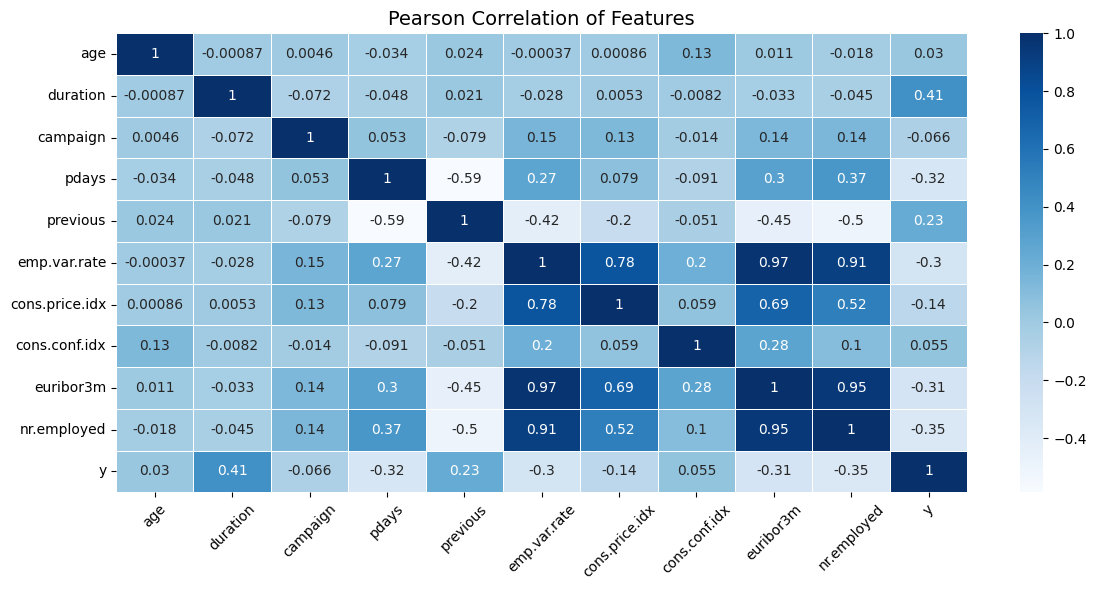

In [7]:
corr = df_new.corr()

# plot the heatmap
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(df_new.corr(), cmap='Blues', annot=True, square=False, linewidth=0.5, 
            xticklabels=corr.columns, yticklabels=corr.columns, annot_kws={"size": 10}, ax=ax)
ax.set_title('Pearson Correlation of Features', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
fig.tight_layout()

- The emp.var.rate, cons.price.idx, euribor3m and nr.employed features have **very high correlation**. 

  With euribor3m and nr.employed having the highest correlation of 0.95
  

# social and economic context attributes

In [8]:
df_new[['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']].describe()

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,1.570960,0.578840,4.628198,1.734447,72.251528
min,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,1.400000,94.767000,-26.900000,5.045000,5228.100000


# EDA on social and economic context attributes

##  employment variation rate

- This variable provides information about the overall economic conditions and may indicate whether the economy is expanding or contracting.

In [9]:
# Employment variation rate, quarterly indicator,this feature have a limited number of unique values which occur repeatedly.
df_new['emp.var.rate'].value_counts(normalize=True)

 1.4    0.394144
-1.8    0.222978
 1.1    0.188477
-0.1    0.089419
-2.9    0.040376
-3.4    0.026003
-1.7    0.018768
-1.1    0.015417
-3.0    0.004176
-0.2    0.000243
Name: emp.var.rate, dtype: float64

In [10]:
df_new = pd.read_csv('bank-additional-full.csv', sep = ';')

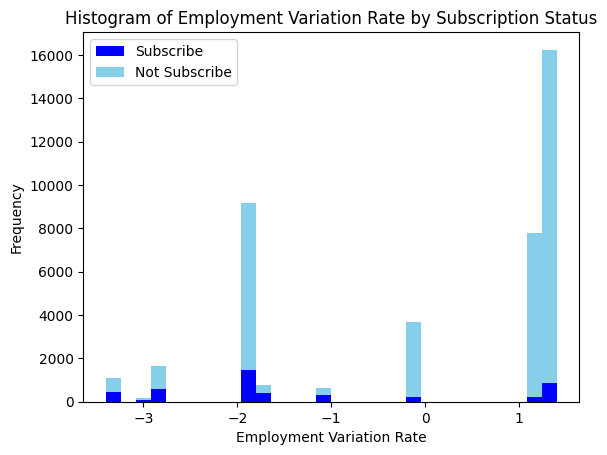

In [11]:
# Create a new DataFrame with the employment variation rate for each class
emp = pd.DataFrame({
    "Subscribe": df_new[df_new["y"]== 'yes']['emp.var.rate'],
    "Not Subscribe":df_new[df_new["y"]== 'no']['emp.var.rate']
})

# Define a list of colors for each class
colors = ["blue", "skyblue"]

# Plot the histogram with the specified colors
emp[["Subscribe","Not Subscribe"]].plot(kind='hist', bins=30, stacked=True, color=colors)

# Add axis labels and a title
plt.xlabel("Employment Variation Rate")
plt.ylabel("Frequency")
plt.title("Histogram of Employment Variation Rate by Subscription Status")

# Show the plot
plt.show()

## Consumer Price 

- This variable provides information about the inflation rate, which is an important economic indicator that can affect consumer behavior.

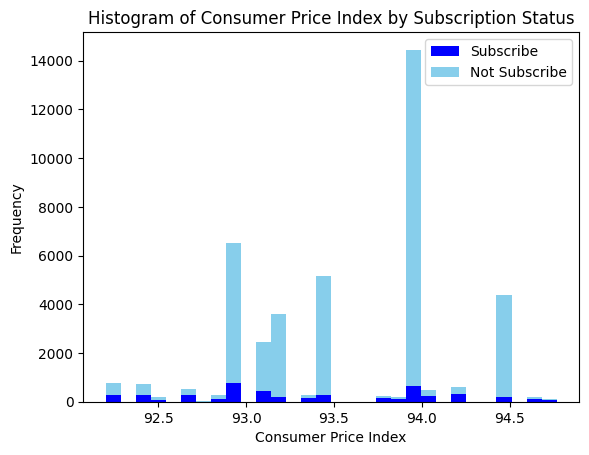

In [13]:
# Create a new DataFrame with the consumer price index for each class

price = pd.DataFrame({
    "Subscribe": df_new[df_new["y"]== 'yes']['cons.price.idx'],
    "Not Subscribe":df_new[df_new["y"]== 'no']['cons.price.idx']
})

# Define a list of colors for each class
colors = ["blue", "skyblue"]

# Plot the histogram with the specified colors
price[["Subscribe","Not Subscribe"]].plot(kind='hist', bins=30, stacked=True, color=colors)

# Add axis labels and a title
plt.xlabel("Consumer Price Index")
plt.ylabel("Frequency")
plt.title("Histogram of Consumer Price Index by Subscription Status")

# Show the plot
plt.show()

## Consumer Confidence

- This variable provides information about consumer sentiment and may indicate whether consumers are optimistic or pessimistic about the future.

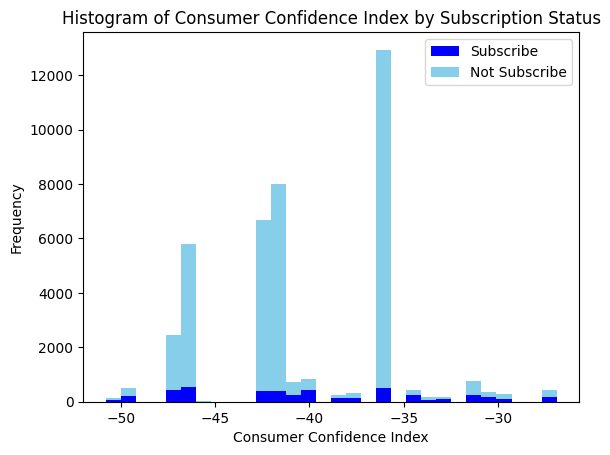

In [14]:
# Create a new DataFrame with the consumer confidence index for each class
conf = pd.DataFrame({
    "Subscribe": df_new[df_new["y"] == "yes"]["cons.conf.idx"],
    "Not Subscribe": df_new[df_new["y"] == "no"]["cons.conf.idx"]
})

# Define a list of colors for each class
colors = ["blue", "skyblue"]

# Plot the histogram with the specified colors
conf[["Subscribe", "Not Subscribe"]].plot(kind="hist", bins=30, stacked=True, color=colors)

# Add axis labels and a title
plt.xlabel("Consumer Confidence Index")
plt.ylabel("Frequency")
plt.title("Histogram of Consumer Confidence Index by Subscription Status")

# Show the plot
plt.show()

## Euribor 3 month rate

- This variable provides information about the cost of borrowing money and may affect consumer behavior.

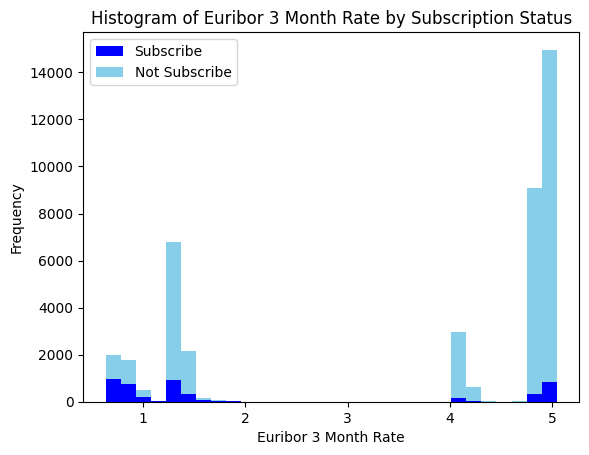

In [15]:
# Create a new DataFrame with the euribor 3 month rate for each class
euribor3m = pd.DataFrame({
    "Subscribe": df_new[df_new["y"] == "yes"]["euribor3m"],
    "Not Subscribe": df_new[df_new["y"] == "no"]["euribor3m"]
})

# Define a list of colors for each class
colors = ["blue", "skyblue"]

# Plot the histogram with the specified colors
euribor3m[["Subscribe", "Not Subscribe"]].plot(kind="hist", bins=30, stacked=True, color=colors)

# Add axis labels and a title
plt.xlabel("Euribor 3 Month Rate")
plt.ylabel("Frequency")
plt.title("Histogram of Euribor 3 Month Rate by Subscription Status")

# Show the plot
plt.show()


## Number of employed people for each class

-  This variable provides information about the overall labor market conditions and may indicate whether the labor market is tight or loose.

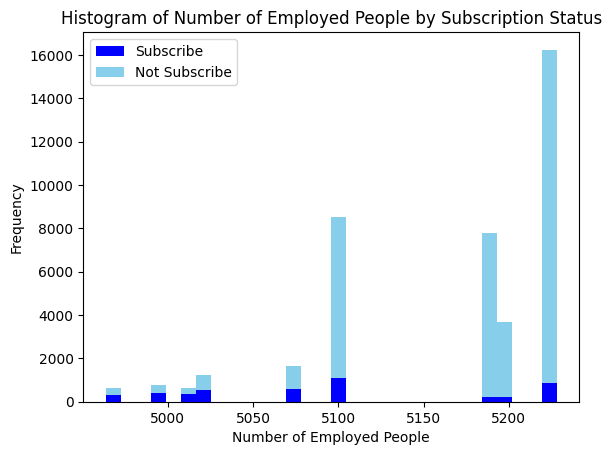

In [16]:
# Create a new DataFrame with the number of employed people for each class
employed = pd.DataFrame({
    "Subscribe": df_new[df_new["y"] == "yes"]["nr.employed"],
    "Not Subscribe": df_new[df_new["y"] == "no"]["nr.employed"]
})

# Define a list of colors for each class
colors = ["blue", "skyblue"]

# Plot the histogram with the specified colors
employed[["Subscribe", "Not Subscribe"]].plot(kind="hist", bins=30, stacked=True, color=colors)

# Add axis labels and a title
plt.xlabel("Number of Employed People")
plt.ylabel("Frequency")
plt.title("Histogram of Number of Employed People by Subscription Status")

# Show the plot
plt.show()


## Imbalanced target value

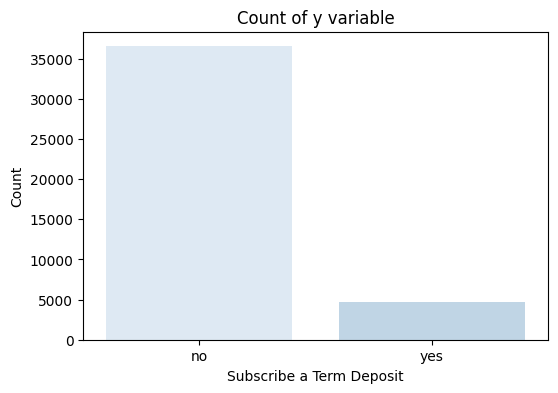

In [17]:
# set the color palette
sns.set_palette("Blues")

# plot the countplot
plt.figure(figsize=(6, 4))
sns.countplot(x='y', data= df_new)
plt.title("Count of y variable")
plt.xlabel("Subscribe a Term Deposit")
plt.ylabel("Count")
plt.show()

#  Pre_processing

### Drop high correalted feature

In [18]:
df_new.drop(['emp.var.rate'], axis=1, inplace=True) 

### Drop Unnecessary Columns 

In [19]:
# According to EDA, some features like day,month have no affect on subscribition

df_new.drop(['day_of_week', 'month'], axis=1, inplace=True) 

- There are no missing values in this dataset. However, there are values labeled as unknown, which can be considered similar to missing values.



- The unknown values for the job and education columns are randomly distributed throughout those columns, indicating that they were not recorded or were otherwise unavailable. In this case, we may want to consider treating these unknown values as missing and imputing them using a suitable imputation method.



- The unknown values for the poutcome column represent the outcome of the previous marketing campaign for customers who were not previously contacted. To handle these values, we could segment the entire column into two categories: success and not success, based on whether the previous marketing campaign was successful or not. This would allow us to retain the information in the poutcome column without introducing missing values into the dataset.

    
- Overall, it is important to carefully consider the treatment of unknown values and missing values in the dataset to ensure that they do not bias the analysis or lead to inaccurate conclusions.

### Impute the Unknown Values

In [20]:
# Define the list of columns to impute
columns_to_impute = ['job', 'education']


# Loop over each column and impute unknown value
for i in columns_to_impute:
    # Compute the normalized value counts for non-unknown values
    value_counts = df_new.loc[df_new[i] != 'unknown', i].value_counts(normalize=True)
    df_new.loc[df_new[i] == 'unknown', i] = np.random.choice(value_counts.index, 
                                                       p = value_counts.values, size = df_new.loc[df_new[i]  == 'unknown'].shape[0] )

In [21]:
# 'unknown', 'failure', and 'other' indicate a lack of success in the previous marketing campaign
# We are replacing these values with 'not success' to simplify the analysis
# Note that the 'success' values are retained as-is
df_new['poutcome'] = df_new['poutcome'].replace({'unknown':'not success', 'failure':'not success', 'other':'not success'})

# Check the unique values in the original column
print(df_new['poutcome'].unique())


['nonexistent' 'not success' 'success']


### Transforem some Columns

In [22]:
df_new = df_new.rename(columns={'y': 'deposit'}) # Rename the target value
df_new['deposit'] = df_new['deposit'].map({'yes': 1, 'no': 0}) # Define new columns for deposit yes and no

df_new['duration'] = df_new['duration'].apply(lambda n: n / 60).round(2) #Change the unit of 'duration' from sec to min

# Encoding

-  According to litreature in the case of imbalanced data, using label encoding could result in an unintended bias towards the majority class. 


- This is because the numerical values assigned to each category may cause the model to treat the majority class as more important than the minority class. On the other hand, using dummy encoding could result in a more balanced representation of the categories, but it may also increase the risk of overfitting to the minority class.


-  However, I try both methods and  got slightly better results on dummy than label encoding.

### Dummy Encoding the Categorical Feature

In [23]:
#Convert categorical variables to dummy variables
df_dummy = pd.get_dummies(df_new[['job', 'marital', 'education', 'poutcome', 'contact']])

# Drop original categorical columns
df_new = df_new.drop(['job', 'marital', 'education', 'poutcome', 'contact'], axis=1)

#First Convert the object to Boolean
df_new['housing'] = df_new['housing'].astype(bool)
df_new['loan'] = df_new['loan'].astype(bool)
df_new['default'] = df_new['default'].astype(bool)

#Convert Boolean variables to integers
df_new['housing'] = df_new['housing'].astype('int')
df_new['loan'] = df_new['loan'].astype('int')
df_new['default'] = df_new['default'].astype('int')

# Concatenate encoded categorical variables with numerical variables
df_new = pd.concat([df_dummy, df_new], axis=1)

#Check the first few rows of the new DataFrame
df_new.head()


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,poutcome_nonexistent,poutcome_not success,poutcome_success,contact_cellular,contact_telephone,age,default,housing,loan,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,deposit
0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,56,1,1,1,4.35,1,999,0,93.994,-36.4,4.857,5191.0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,57,1,1,1,2.48,1,999,0,93.994,-36.4,4.857,5191.0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,37,1,1,1,3.77,1,999,0,93.994,-36.4,4.857,5191.0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,40,1,1,1,2.52,1,999,0,93.994,-36.4,4.857,5191.0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,56,1,1,1,5.12,1,999,0,93.994,-36.4,4.857,5191.0,0


- check another encoding methos to see if it can affect on the modeling results

#  Prepare the features and target variable

In [24]:
X = df_new.drop('deposit',axis=1)
y = df_new['deposit']

In [25]:
X.shape, y.shape

((41188, 39), (41188,))

# Feature Scaling

In [26]:
#Normalize the features
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
x_scaled = scaler.fit_transform(X)
columns = X.columns
X = pd.DataFrame(x_scaled, columns=columns)
#x_scaled contains the normalized features


In [27]:
X

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,poutcome_nonexistent,poutcome_not success,poutcome_success,contact_cellular,contact_telephone,age,default,housing,loan,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,1.200000,0.0,0.0,0.0,0.372928,-0.5,0.0,0.0,0.266594,0.857143,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,1.266667,0.0,0.0,0.0,-0.143646,-0.5,0.0,0.0,0.266594,0.857143,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,-0.066667,0.0,0.0,0.0,0.212707,-0.5,0.0,0.0,0.266594,0.857143,0.000000,0.000000
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.133333,0.0,0.0,0.0,-0.132597,-0.5,0.0,0.0,0.266594,0.857143,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,1.200000,0.0,0.0,0.0,0.585635,-0.5,0.0,0.0,0.266594,0.857143,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.333333,0.0,0.0,0.0,0.709945,-0.5,0.0,0.0,1.107726,-1.428571,-1.058612,-1.762791
41184,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.533333,0.0,0.0,0.0,0.933702,-0.5,0.0,0.0,1.107726,-1.428571,-1.058612,-1.762791
41185,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.200000,0.0,0.0,0.0,0.041436,0.0,0.0,0.0,1.107726,-1.428571,-1.058612,-1.762791
41186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400000,0.0,0.0,0.0,1.207182,-0.5,0.0,0.0,1.107726,-1.428571,-1.058612,-1.762791


# Train-Test Split¶

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((32950, 39), (32950,), (8238, 39), (8238,))

## Cross validation - Stratified sampling 

- Cross validate to check which model performs better 


- Using **stratified** to keeping the target values distibution unchanged

In [29]:
# create a splitter object
stratified = StratifiedShuffleSplit(n_splits=5,test_size=0.2, random_state=42) 

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Define the models to compare
models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('KNN', KNeighborsClassifier()),
    ('Random Forest', RandomForestClassifier(random_state=42))
]

# Calculate cross-validation scores for each model
for name, model in models:
    cv_score = cross_val_score(estimator=model, X=X_train, y=y_train, scoring='accuracy', cv=stratified)
    print(f'{name} CV Score:', cv_score.mean())


Logistic Regression CV Score: 0.9100758725341427
KNN CV Score: 0.8999089529590287
Random Forest CV Score: 0.9125644916540212


- we can not make a decision based on cross validation becase all the models perform quite similar



- Hence based on cross validation on the train set,  all of the three models are quite good, and does not give significant difference



- in doing the cross validation we have to sure our model is not overfitted(e.g., random forest was overfitted and we change the parameters)

# Model Building

The target value is "deposit", a "Yes/No" variable. Therefore, Classification predictive models or Binary Classification Algorithms are suitable for developing the models.
In this report, the authors decided to use some popular models, which are:

Logistic Regression.
Knn.
Random Forest.

# Logistic Regression

In [31]:
# Fit Logistic Regression model on the training data
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Evaluate the performance on the training data
train_accuracy = lr.score(X_train, y_train)
print("Training accuracy:", train_accuracy)

# Evaluate the performance on the test data
test_prediction = lr.predict(X_test)
test_accuracy = accuracy_score(y_test, test_prediction)
print("Test accuracy:", test_accuracy)

# Check for overfitting by comparing train and test accuracy
if abs(train_accuracy - test_accuracy) > 0.1:
    print("Warning: Overfitting detected")

# Train and test accuracy are quite close so we don't seem to have too much overfitting

# evaluate
confusion_matrix(y_test,test_prediction)

Training accuracy: 0.909711684370258
Test accuracy: 0.9133284777858703


array([[7156,  154],
       [ 560,  368]], dtype=int64)

In [32]:
# fn :model say no deposit but they actually deposit
# fp :model say deposit but they actullay NOT deposit

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, test_prediction).ravel()

print("Confusion matrix:")
print(f"True negatives: {tn}")
print(f"False positives: {fp}")
print(f"False negatives: {fn}")
print(f"True positives: {tp}")

Confusion matrix:
True negatives: 7156
False positives: 154
False negatives: 560
True positives: 368


In [33]:
print(classification_report(y_test,test_prediction))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7310
           1       0.70      0.40      0.51       928

    accuracy                           0.91      8238
   macro avg       0.82      0.69      0.73      8238
weighted avg       0.90      0.91      0.90      8238



# K Nearest Neighbour

In [34]:
# Fit model on the training data
np.random.seed(42)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

# Evaluate the performance on the training data
train_accuracy = knn.score(X_train, y_train)
print("Training accuracy:", train_accuracy)

# Evaluate the performance on the test data
test_prediction = knn.predict(X_test)
test_accuracy = accuracy_score(y_test, test_prediction)
print("Test accuracy:", test_accuracy)

# Check for overfitting by comparing train and test accuracy
if abs(train_accuracy - test_accuracy) > 0.1:
    print("Warning: Overfitting detected")

# Train and test accuracy are quite close so we don't seem to have too much overfitting

# evaluate
confusion_matrix(y_test,test_prediction)

Training accuracy: 0.9166312594840668
Test accuracy: 0.907623209516873


array([[7136,  174],
       [ 587,  341]], dtype=int64)

In [35]:
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, test_prediction).ravel()

print("Confusion matrix:")
print(f"True negatives: {tn}")
print(f"False positives: {fp}")
print(f"False negatives: {fn}")
print(f"True positives: {tp}")

Confusion matrix:
True negatives: 7136
False positives: 174
False negatives: 587
True positives: 341


In [36]:
print(classification_report(y_test,test_prediction))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7310
           1       0.66      0.37      0.47       928

    accuracy                           0.91      8238
   macro avg       0.79      0.67      0.71      8238
weighted avg       0.89      0.91      0.90      8238



# Random forest

In [37]:
# Fit Random Forest model on the training data
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Evaluate the performance on the training data
train_accuracy = rf.score(X_train, y_train)
print("Training accuracy:", train_accuracy)

# Evaluate the performance on the test data
test_prediction = rf.predict(X_test)
test_accuracy = accuracy_score(y_test, test_prediction)
print("Test accuracy:", test_accuracy)

# Check for overfitting by comparing train and test accuracy
if abs(train_accuracy - test_accuracy) > 0.1:
    print("Warning: Overfitting detected")

# Train and test accuracy are quite close so we don't seem to have too much overfitting

# evaluate
confusion_matrix(y_test,test_prediction)

Training accuracy: 0.9999696509863429
Test accuracy: 0.9163631949502307


array([[7071,  239],
       [ 450,  478]], dtype=int64)

In [38]:
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, test_prediction).ravel()

print("Confusion matrix:")
print(f"True negatives: {tn}")
print(f"False positives: {fp}")
print(f"False negatives: {fn}")
print(f"True positives: {tp}")

Confusion matrix:
True negatives: 7071
False positives: 239
False negatives: 450
True positives: 478


In [39]:
print(classification_report(y_test,test_prediction))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7310
           1       0.67      0.52      0.58       928

    accuracy                           0.92      8238
   macro avg       0.80      0.74      0.77      8238
weighted avg       0.91      0.92      0.91      8238



## Create List for Collecting the Results

In [40]:
# two empthy list to append all the results

accu = []
methods = []

## This function is to plot the confusion matrix

In [41]:
def plot_confusion_matrix(y_test, y_pred, labels=None):
    """
    Plot a confusion matrix for the given true and predicted labels.
    Optionally, provide a list of label names to use for the plot.
    """
    if labels is None:
        labels = np.unique(y_pred)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_title('Confusion Matrix')
    plt.show()


# Hyper Parameters Tuning the Models

### Hyperparameters tuning GridSearch for  Logistic Regression

- The highest class weight in this list assigns 50 times more weight to the positive class (class 1) than to the negative class (class 0). 


- This should give the model enough flexibility to find the best trade-off between precision and recall, while still accounting for the class imbalance.

In [42]:
%%time

# Define logistic regression model
lr_cv = LogisticRegression(random_state=42)


# Define the range of class_weight
#'class_weight': [{0: 1, 1: w} for w in np.linspace(1, 50, 50)] -> better


#class_freq = dict(df['deposit'].value_counts(normalize=True))
#class_weights = []
#for cls, freq in class_freq.items():
    #weight = len(df) / (len(class_freq) * freq)
    #class_weights.append({cls: weight})

class_weights = [{0: 1, 1: w} for w in [3, 5, 7, 10,12]] 

# Define hyperparameters to search over
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3, 3, 7),
    'class_weight': class_weights,
    'solver': ['liblinear', 'saga']}


# Create GridSearchCV object
grid_search = GridSearchCV(lr_cv, param_grid, cv=stratified, scoring='f1_macro')

# Fit grid search to training data
grid_search.fit(X_train, y_train)

# Get the best estimator and score
best_lr = grid_search.best_estimator_  # best combination of hyperparameters 
best_score = grid_search.best_score_    # refers to the value of the scoring metric achieved by the best estimator.

# Evaluate the best estimator on the test data
y_pred = best_lr.predict(X_test)
test_score = f1_score(y_test, y_pred)

print(f"Best F1 score: {best_score}")
print(f"Test F1 score: {test_score}")

Best F1 score: 0.7730131019281368
Test F1 score: 0.6231253023705854
CPU times: total: 17min
Wall time: 29min 32s


In [43]:
print('tuned hyperparameters: (best parameters)', grid_search.best_params_)

tuned hyperparameters: (best parameters) {'C': 0.1, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1', 'solver': 'liblinear'}


In [44]:
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("Confusion matrix:")
print(f"True negatives: {tn}")
print(f"False positives: {fp}")
print(f"False negatives: {fn}")
print(f"True positives: {tp}")

Confusion matrix:
True negatives: 6815
False positives: 495
False negatives: 284
True positives: 644


In [45]:
# appeand the test results
# Evaluate the best estimator on the test data

accu.append(best_lr.score(X_test,y_test))
methods.append('Logistic Regression')
print('X_test Accuracy:', best_lr.score(X_test,y_test))

X_test Accuracy: 0.9054382131585337


## Confusion Matrix for logistic Regression

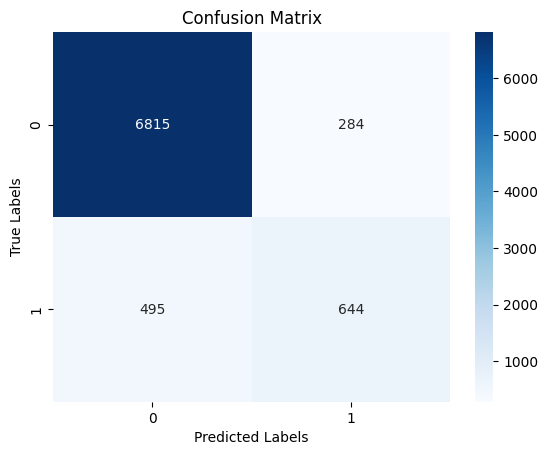

In [46]:
predictions= best_lr.predict(X_test)

plot_confusion_matrix(predictions, y_test, labels=[0, 1])

- the position of false negatives and false positives is different in the output of a general matrix in Python and a confusion matrix 

In [47]:
print(classification_report(y_test,predictions,target_names=['not deposit', 'deposit']))

              precision    recall  f1-score   support

 not deposit       0.96      0.93      0.95      7310
     deposit       0.57      0.69      0.62       928

    accuracy                           0.91      8238
   macro avg       0.76      0.81      0.78      8238
weighted avg       0.92      0.91      0.91      8238



- Low recall means that model is struggling with classifying deposit cases

- As we try to decrease both false positive and false negative, the f1 score can be excellent metric.


- The ROC and AUC is also an intrsting metric that can show the model's effectiveness. 


- AUC closer to 1 means the model is highly effective

### Hyperparameters tuning GridSearch for KNN

In [48]:
%%time


# Create a k-NN classifier with class weights
knn_cv = KNeighborsClassifier(n_neighbors=10, weights='distance') # How to weight each neigbour 
                                                                  #gives more weight to close neighbour

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# classes are the unique class labels in y_train
#classes = np.unique(y_train)

# compute the class weights based on inverse of class frequency
#class_weights = compute_class_weight('balanced', classes, y_train)


# Compute class weights
#class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)


## Define hyperparameters to search over
param_grid = {'n_neighbors': [3, 5, 7, 9],
              'algorithm': ['auto'],
              'weights': ['distance', 'uniform']}

# Create GridSearchCV object
grid_search = GridSearchCV(knn_cv, param_grid, cv=stratified, scoring='f1_macro',n_jobs=-1)# f1_macro-> imbalanced data


# Fit grid search to training data
grid_search.fit(X_train, y_train)


# Get the best estimator and score
best_knn = grid_search.best_estimator_  #obtain the best estimator from the grid search 
best_score = grid_search.best_score_


# Evaluate the best estimator on the test data
y_pred = best_knn.predict(X_test)
test_score = f1_score(y_test, y_pred)

print(f"Best F1 score: {best_score}")
print(f"Test F1 score: {test_score}")

Best F1 score: 0.7215394823552262
Test F1 score: 0.52179406190777
CPU times: total: 4.03 s
Wall time: 44 s


In [49]:
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("Confusion matrix:")
print(f"True negatives: {tn}")
print(f"False positives: {fp}")
print(f"False negatives: {fn}")
print(f"True positives: {tp}")

Confusion matrix:
True negatives: 7068
False positives: 242
False negatives: 515
True positives: 413


In [50]:
print('tuned hyperparameters: (best parameters)', grid_search.best_params_)

tuned hyperparameters: (best parameters) {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'distance'}


## Calculate the confusion matrix for KNN

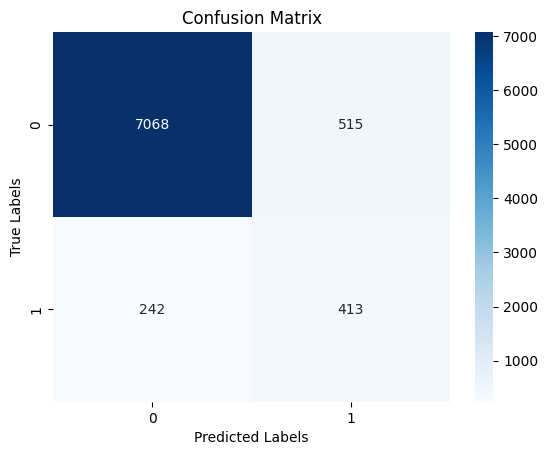

In [51]:
y_pred= best_knn.predict(X_test)

plot_confusion_matrix(y_pred, y_test, labels=[0, 1])

# KNN test Result

In [52]:
accu.append(best_knn.score(X_test,y_test))
methods.append('KNN')
print('X_test Acuracy:',best_knn.score(X_test,y_test))

X_test Acuracy: 0.9081087642631707


In [53]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7310
           1       0.63      0.45      0.52       928

    accuracy                           0.91      8238
   macro avg       0.78      0.71      0.74      8238
weighted avg       0.90      0.91      0.90      8238



## Hyperparameters tuning GridSearch Random Forest

In [54]:
%%time



# Define the random forest classifier 
rf_1 = RandomForestClassifier(random_state=42)


# Define the class_weight (gives equall importance to the classes)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
# Number of trees in random forest
n_estimators = [10, 30, 50, 70, 100, 120, 150],
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [3, 5, 7, 9]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]


parameters = {'n_estimators': n_estimators , 
                  'criterion' : [ 'entropy'], 
                  'max_depth': max_depth, 
                  'max_features': ['auto','sqrt'],
             'min_samples_split':min_samples_split,
             'min_samples_leaf':min_samples_leaf,
            'class_weight':class_weights}


# Define the resampling technique (ensure the model have enough samples from the minority)
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)

# Define the GridSearch Object
rf_cv = GridSearchCV(rf_1,parameters, cv=stratified, scoring='f1_macro', n_jobs=-1)



# Fit grid search to training data
grid_search.fit(X_train, y_train)


# Get the best estimator and score
best_rf = grid_search.best_estimator_  #obtain the best estimator from the grid search 
best_score = grid_search.best_score_


# Evaluate the best estimator on the test data
y_pred = best_rf.predict(X_test)
test_score = f1_score(y_test, y_pred)

print(f"Best F1 score: {best_score}")
print(f"Test F1 score: {test_score}")

Best F1 score: 0.7215394823552262
Test F1 score: 0.52179406190777
CPU times: total: 4.58 s
Wall time: 29.7 s


# Random Forest test Result

In [55]:
accu.append(best_rf.score(X_test,y_test))
methods.append('Random Forest')
print('X_test Acuracy:',best_rf.score(X_test,y_test))

X_test Acuracy: 0.9081087642631707


## Confusion matrix for Random Forest

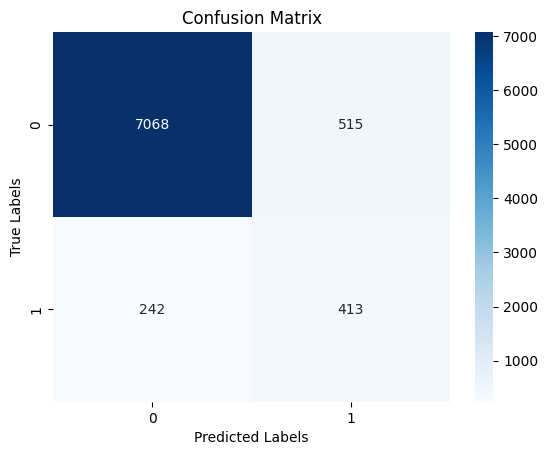

In [56]:
y_pred= best_rf.predict(X_test)

plot_confusion_matrix(y_pred, y_test, labels=[0, 1])

In [57]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7310
           1       0.63      0.45      0.52       928

    accuracy                           0.91      8238
   macro avg       0.78      0.71      0.74      8238
weighted avg       0.90      0.91      0.90      8238



# The Best Performed Model

In [58]:
print(methods)
print(accu)

['Logistic Regression', 'KNN', 'Random Forest']
[0.9054382131585337, 0.9081087642631707, 0.9081087642631707]


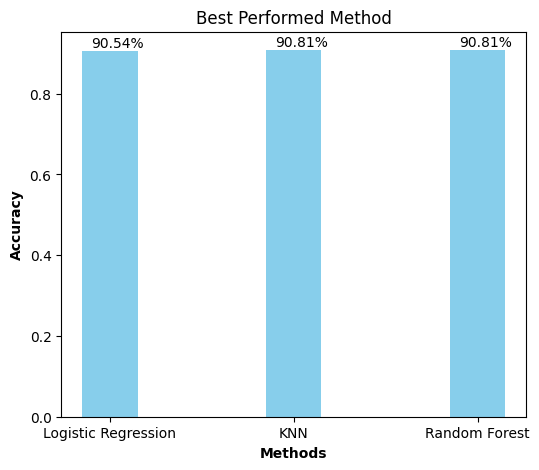

In [69]:
fig=plt.figure(figsize=(6,5))

#creating the bar plot
plt.bar(methods,accu,color='skyblue',width=0.3)

for i, v in enumerate(accu):
    plt.text(i - 0.1, v + 0.01, str(round(v*100, 2))+'%', fontsize=10, color='black')


plt.xlabel('Methods',weight='bold')
plt.ylabel('Accuracy',weight='bold')
plt.title('Best Performed Method')
plt.show()

# Model Effectivness


### see ROC Curve (Receiver Operating Curve) & AUC

- The ROC curve tells us how well our classifier is classifying between term deposit suscriptions (True Positives) and non-term deposit suscriptions. 


- The X-axis is represented by False positive rates (Specificity) and the Y-axis is represented by the True Positive Rate (Sensitivity.) 


- As the line moves the threshold of the classification changes giving us different values. The closer is the line to our top left corner the better is our model separating both classes.

Text(0.5, 1.0, 'Area under ROC')

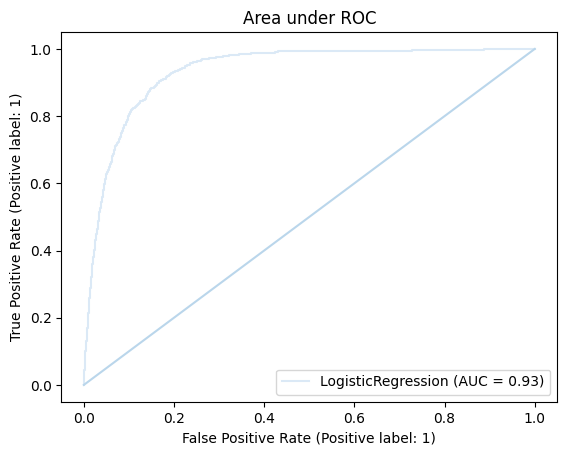

In [60]:
RocCurveDisplay.from_estimator(best_lr,X_test,y_test)
plt.plot([0,1],[0,1])
plt.title('Area under ROC')

Text(0.5, 1.0, 'Area under ROC')

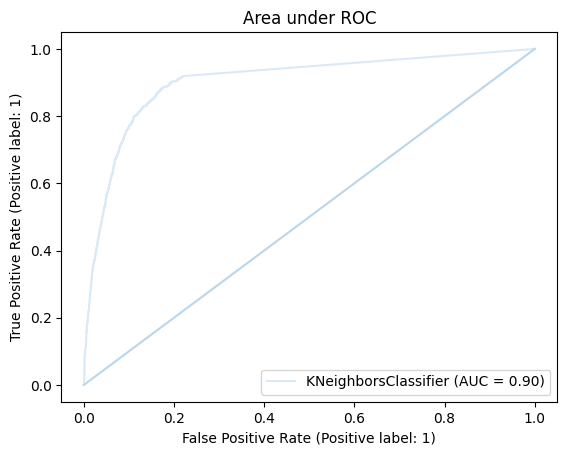

In [61]:
RocCurveDisplay.from_estimator(best_knn,X_test,y_test)
plt.plot([0,1],[0,1])
plt.title('Area under ROC')

Text(0.5, 1.0, 'Area under ROC')

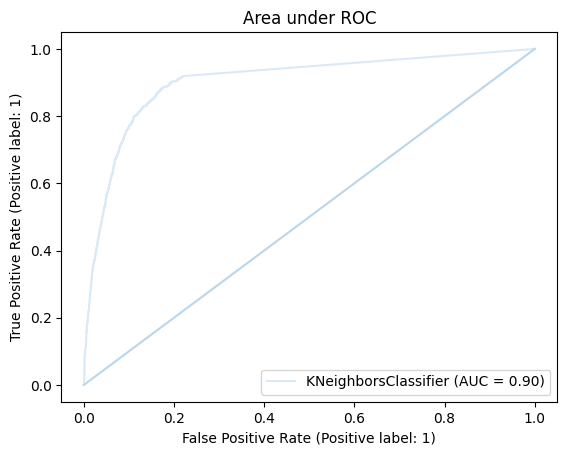

In [62]:
RocCurveDisplay.from_estimator(best_rf,X_test,y_test)
plt.plot([0,1],[0,1])
plt.title('Area under ROC')

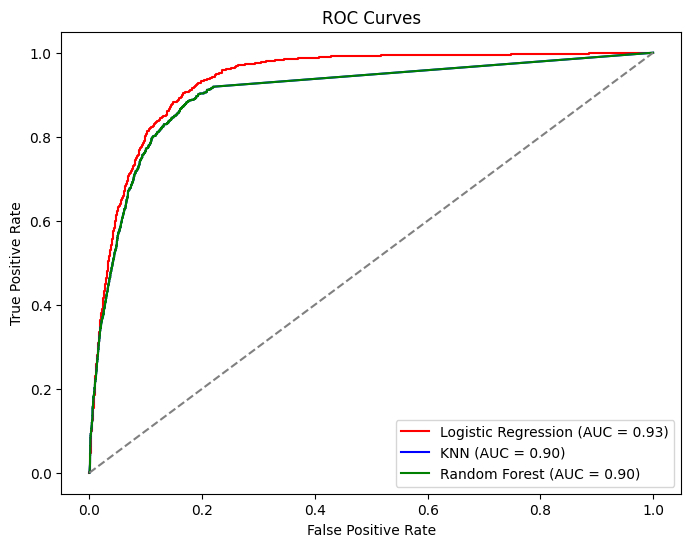

In [68]:
from sklearn.metrics import RocCurveDisplay

# Define colors for each model
colors = {'Logistic Regression': 'red', 'KNN': 'blue', 'Random Forest': 'green'}

# Create a figure and axes object
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the ROC curve for each model, using a different color for each line
RocCurveDisplay.from_estimator(best_lr, X_test, y_test, ax=ax, name='Logistic Regression', color=colors['Logistic Regression'])
RocCurveDisplay.from_estimator(best_knn, X_test, y_test, ax=ax, name='KNN', color=colors['KNN'])
RocCurveDisplay.from_estimator(best_rf, X_test, y_test, ax=ax, name='Random Forest', color=colors['Random Forest'])

# Plot the diagonal line
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Add axis labels and a title
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves')

# Add a legend
ax.legend()


**Discussion on Evaluation** 


- Confusion matrix (recall_score, f1_score) and Receiver Operating Characteristics (ROC) curve were used for evaluation.


- These metrics were chosen due to the highly imbalanced data, skewed towards the negative side (loss).


- F1_score was used to detect the harmonic mean between sensitivity and specificity.


- Higher recall score was preferred over higher precision due to the importance of identifying customers who will subscribe for a term deposit.



**Conclusion**

- Adding more features to a problem improved the accuracy by providing more information to the algorithm.


- The ROC curve shows a logistic regression as better suited to the data after adding more features.
